In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import pickle

### Učitavanje podataka

In [2]:
# Učitavanje df_account_value_sac
with open('nflx_primorl_df_account_value_ppo.pkl', 'rb') as f:
    df_account_value = pickle.load(f)

# Učitavanje df_actions_sac
with open('nflx_primorl_df_actions_ppo.pkl', 'rb') as f:
    df_actions = pickle.load(f)

# Učitavanje buy_and_hold
with open('nflx_primorl_buy_and_hold.pkl', 'rb') as f:
    buy_and_hold = pickle.load(f)

### Plot grafa agenta s točkama kupnje i prodaje

/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_61576/2283147447.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


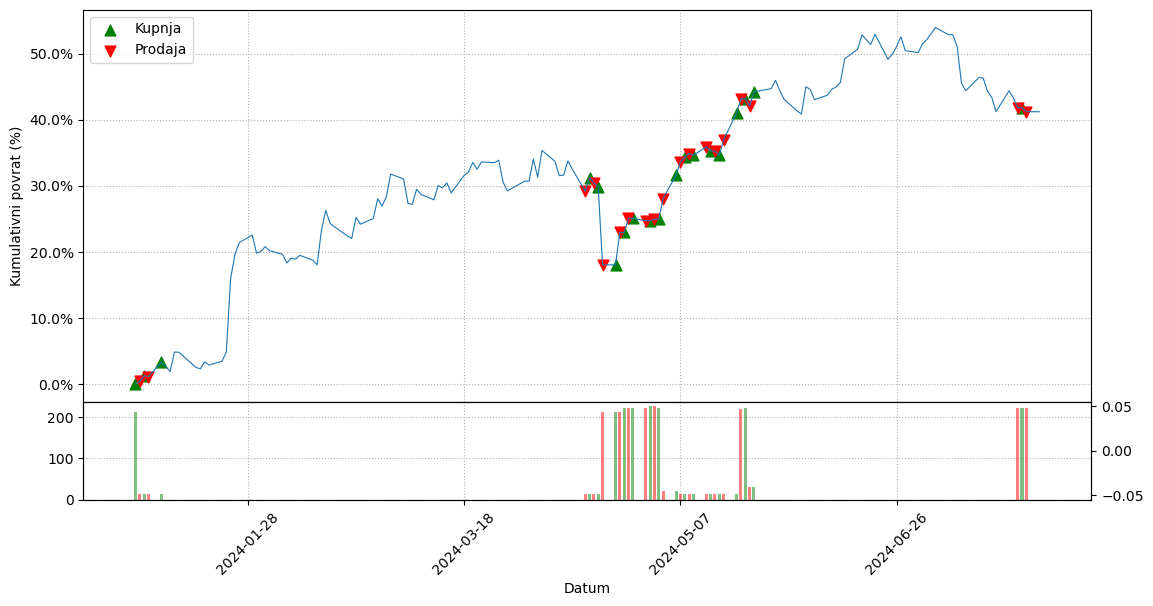

In [3]:
# Pripremamo podatke za mplfinance
df = df_account_value.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Izračun kumulativnog povrata
initial_value = df['account_value'].iloc[0]
df['cumulative_return'] = (df['account_value'] / initial_value - 1) * 100

df['Open'] = df['Close'] = df['High'] = df['Low'] = df['cumulative_return']
df['Volume'] = 0  # Inicijaliziramo volumen na 0

# Pripremamo df_actions
df_actions['date'] = pd.to_datetime(df_actions['date'])
df_actions.set_index('date', inplace=True)

# Dodajemo volumen
df.loc[df_actions.index, 'Volume'] = df_actions['actions'].apply(lambda x: abs(x[0]))

# Stvaramo serije za kupnje i prodaje
buys = pd.Series(index=df.index, data=False)
sells = pd.Series(index=df.index, data=False)

for date, action in df_actions.iterrows():
    if date in df.index:
        if action['actions'][0] > 0:
            buys[date] = True
        elif action['actions'][0] < 0:
            sells[date] = True

# Postavljamo stil grafikona
mc = mpf.make_marketcolors(up='g', down='r', volume='inherit', edge='inherit', wick='inherit')
s = mpf.make_mpf_style(marketcolors=mc, gridstyle=':', y_on_right=False)

# Stvaramo dodatne plotove za kupnje, prodaje i volumen
apds = [
    mpf.make_addplot(df['Close'].where(buys), type='scatter', markersize=60, marker='^', color='g'),
    mpf.make_addplot(df['Close'].where(sells), type='scatter', markersize=60, marker='v', color='r'),
    mpf.make_addplot(df['Volume'].where(buys), type='bar', width=0.7, panel=1, color='g', alpha=0.5),
    mpf.make_addplot(df['Volume'].where(sells), type='bar', width=0.7, panel=1, color='r', alpha=0.5),
    mpf.make_addplot(df['Volume'].where(~buys & ~sells), type='bar', width=0.7, panel=1, color='gray', alpha=0.5)
]

# Crtamo grafikon i vraćamo figure i axes objekte
fig, axes = mpf.plot(df, type='line', style=s, addplot=apds,
         xlabel='Datum',
         ylabel='Kumulativni povrat (%)',
         figsize=(14, 7),  # Smanjujemo veličinu grafa
         panel_ratios=(4,1),  # Omjer glavnog grafikona i volumena
         xrotation=45,
         tight_layout=False,  # Isključujemo automatski tight_layout
         show_nontrading=True,
         datetime_format='%Y-%m-%d',  # Prikazivanje datuma brojčano
         volume=False,  # Isključujemo standardni prikaz volumena
         returnfig=True)  # Vraćamo figure i axes objekte

# Dodajemo legendu
buy_scatter = plt.scatter([], [], s=60, marker='^', color='g', label='Kupnja')
sell_scatter = plt.scatter([], [], s=60, marker='v', color='r', label='Prodaja')
axes[0].legend(handles=[buy_scatter, sell_scatter], loc='upper left')

# Postavljamo y-os da prikazuje postotke
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

# Prilagođavamo raspored
plt.tight_layout()

plt.show()

### Plot grafa agenta i buy and hold s točkama kupnje i prodaje

/var/folders/28/0nrxt8bn57bdz8wy1xv7fb6m0000gn/T/ipykernel_61576/2916548913.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


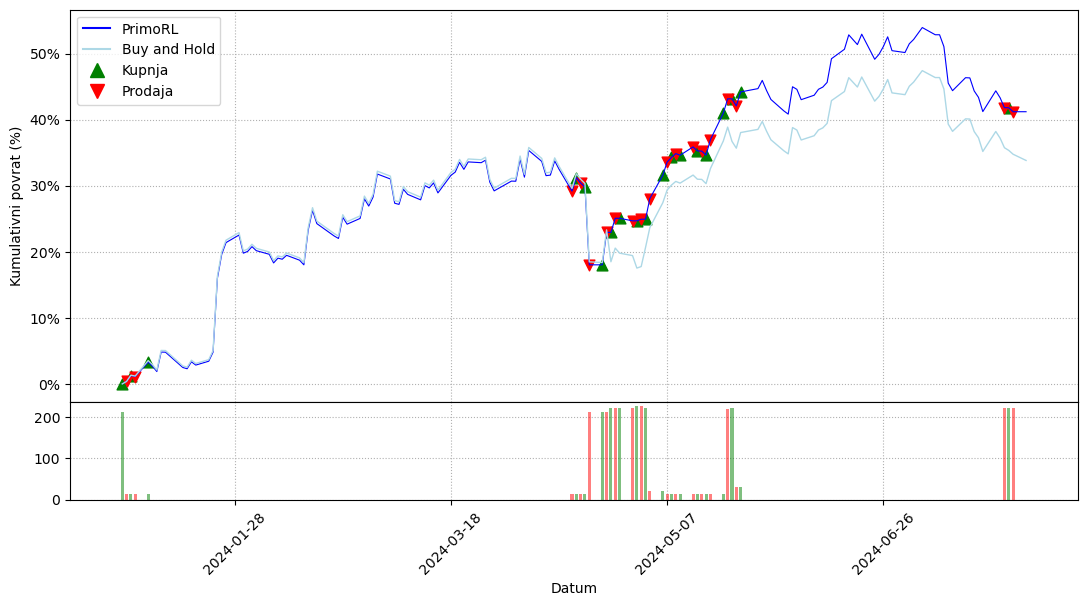

In [4]:
# Pripremamo podatke za mplfinance
df = df_account_value.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Izračun kumulativnog povrata za PPO
initial_value_ppo = df['account_value'].iloc[0]
df['cumulative_return'] = (df['account_value'] / initial_value_ppo - 1) * 100
df['Open'] = df['Close'] = df['High'] = df['Low'] = df['cumulative_return']
df['Volume'] = 0

# Dodajemo volumen i označavamo kupnje i prodaje
df.loc[df_actions.index, 'Volume'] = df_actions['actions'].apply(lambda x: abs(x[0]))
buys = pd.Series(False, index=df.index)
sells = pd.Series(False, index=df.index)
buys.loc[df_actions[df_actions['actions'].apply(lambda x: x[0] > 0)].index] = True
sells.loc[df_actions[df_actions['actions'].apply(lambda x: x[0] < 0)].index] = True

# Postavljamo stil grafikona
mc = mpf.make_marketcolors(up='g', down='r', volume='inherit', edge='inherit', wick='inherit')
s = mpf.make_mpf_style(marketcolors=mc, gridstyle=':', y_on_right=False)

# Pripremamo buy_and_hold podatke
buy_and_hold.index = pd.to_datetime(buy_and_hold.index)
buy_and_hold = buy_and_hold.reindex(df.index).ffill()

# Izračun kumulativnog povrata za Buy & Hold
initial_value_bh = buy_and_hold['close'].iloc[0]
buy_and_hold['cumulative_return'] = (buy_and_hold['close'] / initial_value_bh - 1) * 100

# Definiramo boje
ppo_color = 'blue'
buy_hold_color = 'lightblue'

# Stvaramo dodatne plotove
apds = [
    mpf.make_addplot(df['Close'].where(buys), type='scatter', markersize=60, marker='^', color='g'),
    mpf.make_addplot(df['Close'].where(sells), type='scatter', markersize=60, marker='v', color='r'),
    mpf.make_addplot(df['Volume'].where(buys), type='bar', width=0.7, panel=1, color='g', alpha=0.5),
    mpf.make_addplot(df['Volume'].where(sells), type='bar', width=0.7, panel=1, color='r', alpha=0.5),
    mpf.make_addplot(buy_and_hold['cumulative_return'], color=buy_hold_color, width=1, label='Buy & Hold')
]

# Crtamo grafikon
fig, axes = mpf.plot(df, type='line', style=s, addplot=apds,
                     xlabel='Datum', ylabel='Kumulativni povrat (%)',
                     figsize=(14, 7), panel_ratios=(4,1), xrotation=45,
                     tight_layout=False, show_nontrading=True,
                     datetime_format='%Y-%m-%d', volume=False, returnfig=True,
                     linecolor=ppo_color)  # Postavljamo boju PPO linije

# Dodajemo legendu
legend_elements = [
    plt.Line2D([], [], color=ppo_color, label='PrimoRL'),
    plt.Line2D([], [], color=buy_hold_color, label='Buy and Hold'),
    plt.Line2D([], [], marker='^', color='g', linestyle='None', markersize=10, label='Kupnja'),
    plt.Line2D([], [], marker='v', color='r', linestyle='None', markersize=10, label='Prodaja')
]
axes[0].legend(handles=legend_elements, loc='upper left')

# Postavljamo y-os da prikazuje postotke bez decimalnih mjesta
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x)}%'))

# Prilagođavamo raspored
plt.tight_layout()
plt.show()

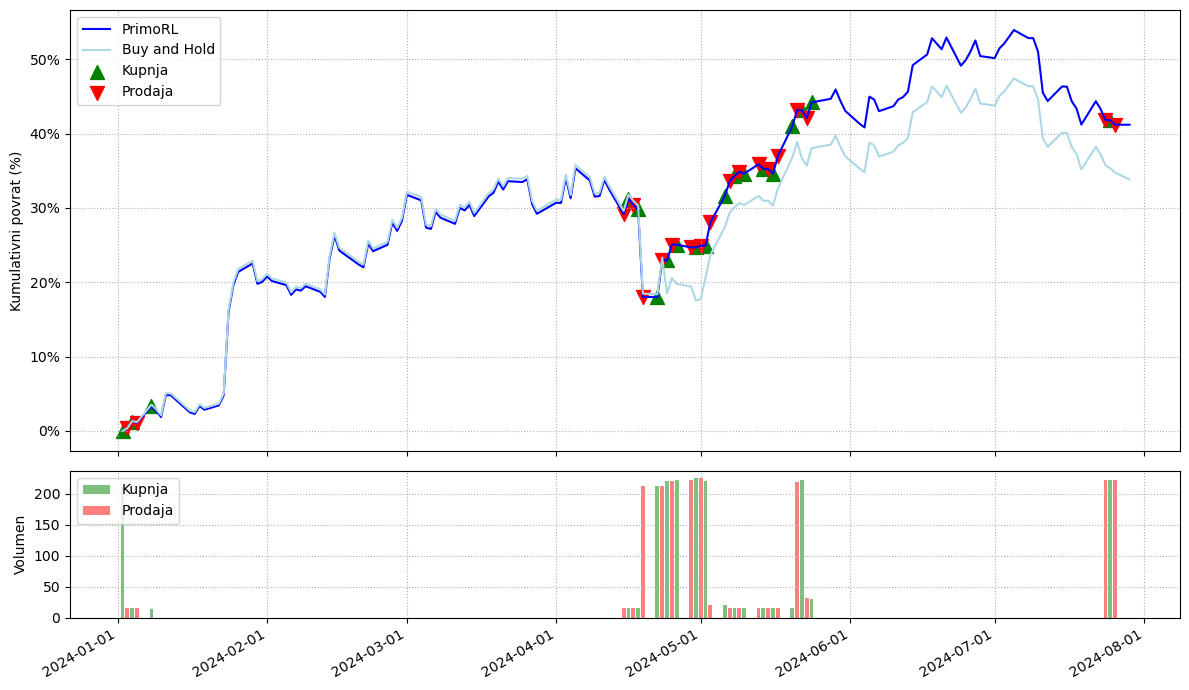

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Pripremamo podatke
df = df_account_value.copy()
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Izračun kumulativnog povrata za PPO i Buy & Hold
initial_value_ppo = df['account_value'].iloc[0]
df['cumulative_return'] = (df['account_value'] / initial_value_ppo - 1) * 100

buy_and_hold.index = pd.to_datetime(buy_and_hold.index)
buy_and_hold = buy_and_hold.reindex(df.index).ffill()
initial_value_bh = buy_and_hold['close'].iloc[0]
buy_and_hold['cumulative_return'] = (buy_and_hold['close'] / initial_value_bh - 1) * 100

# Pripremamo podatke za kupnje i prodaje
buys = df_actions[df_actions['actions'].apply(lambda x: x[0] > 0)]
sells = df_actions[df_actions['actions'].apply(lambda x: x[0] < 0)]

# Stvaramo graf
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

# Crtamo glavne linije
ax1.plot(df.index, df['cumulative_return'], color='blue', label='PrimoRL')
ax1.plot(buy_and_hold.index, buy_and_hold['cumulative_return'], color='lightblue', label='Buy and Hold')

# Dodajemo točke za kupnje i prodaje
ax1.scatter(buys.index, df.loc[buys.index, 'cumulative_return'], color='green', marker='^', s=100, label='Kupnja')
ax1.scatter(sells.index, df.loc[sells.index, 'cumulative_return'], color='red', marker='v', s=100, label='Prodaja')

# Postavljamo y-os da prikazuje postotke bez decimalnih mjesta
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x)}%'))

# Dodajemo legendu
ax1.legend(loc='upper left')

# Postavljamo naslov i oznake osi
#ax1.set_title('Kumulativni povrat')
ax1.set_ylabel('Kumulativni povrat (%)')

# Crtamo volumen
ax2.bar(buys.index, buys['actions'].apply(lambda x: abs(x[0])), color='green', alpha=0.5, label='Kupnja')
ax2.bar(sells.index, sells['actions'].apply(lambda x: abs(x[0])), color='red', alpha=0.5, label='Prodaja')

ax2.set_ylabel('Volumen')
ax2.legend(loc='upper left')

# Formatiramo x-os
plt.gcf().autofmt_xdate()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.tight_layout()
plt.show()